In [1070]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import numpy as np
import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

random.seed(67890)

In [1071]:
class Box(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = 1

In [1072]:
class Robot(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = 2
        self.box_carried = False
        self.has_tower = False
        self.tower_coord = None

    def moveRandom(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def look4tower(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        has_box = False
        for neighbor in neighbors:
            if neighbor.isBox():
                has_box = True
        if has_box:
            self.markTower()
        else:
            self.moveRandom()

    def markTower(self):
        possibles = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        for possible in possibles:
            if possible in self.model.towers:
                possibles.remove(possible)
        
        # Get Neighbors Positions
        positions = set()
        for possible in possibles:
            pos = possible.pos
            positions.add(pos)
        
        # Get the highest box count from neighbors
        count = 0
        tower_pos = None
        for position in positions:
            box_count  = self.model.boxes[position[0]][position[1]]
            if box_count > count:
                count = box_count
                tower_pos = position
                # Set the robot tower coord
                self.tower_coord = tower_pos

        # Mark the tower
        self.has_tower = True
        self.model.towers.append(tower_pos)
       
    # TODO
    def look4Box(self): 



    # def move2tower(self):


    def step(self):
        self.markTower()
        # if not self.box_carried and not self.has_tower:
        #     self.look4tower()
        # elif not self.box_carried and self.has_tower:
        #     self.look4Box()
        # elif self.box_carried and self.has_tower:
        #     self.move2tower()

In [1073]:
def get_grid(model):
    grid = np.zeros((model.width, model.height))
    for (contents, (x, y)) in model.grid.coord_iter():
        for content in contents:
            if isinstance(content, Box):
                grid[x][y] = model.boxes[x][y]
            elif isinstance(content, Robot):
                grid[x][y] = 10

    return grid

In [1074]:
class WarehouseModel(Model):
    def __init__(self, width, height, num_agents, num_boxes):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.num_boxes = num_boxes

        self.boxes = np.zeros((width, height))
        self.towers = []

        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        # Place agents
        robotId = 0
        for _ in range(self.num_agents):
            a = Robot(robotId, self)
            self.schedule.add(a)
            pos = self.random_empty_cell()
            while self.is_box(pos):
                pos = self.random_empty_cell()
            self.grid.place_agent(a, pos)
            robotId += 1

        # Place boxes
        boxId = 10
        for _ in range(self.num_boxes):
            b = Box(boxId, self)
            self.schedule.add(b)
            pos = self.random_position()
            while self.init_full(pos):
                pos = self.random_position()
            self.grid.place_agent(b, pos)
            self.boxes[pos[0]][pos[1]] += 1
            boxId += 1
            
        # for _ in range(self.num_boxes):
        #     pos = self.random_position()
        #     while self.init_full(pos):
        #         pos = self.random_position()
        #     self.boxes[pos[0]][pos[1]] += 1

    def is_box(self, pos):
        return self.boxes[pos[0]][pos[1]] > 0
    
    def init_full(self, pos):
        return self.boxes[pos[0]][pos[1]] == 3
    
    def is_tower_full(self, pos):
        return self.boxes[pos[0]][pos[1]] == 5

    def pick_box(self, pos):
        if self.is_box(pos):
            self.boxes[pos[0]][pos[1]] -= 1

    def place_box(self, pos):
        self.boxes[pos[0]][pos[1]] += 1

    def count_carried_boxes(self):
        return sum(agent.box_carried for agent in self.schedule.agents)

    def random_empty_cell(self):
        empty_cells = [(x, y) for x in range(self.width) for y in range(self.height) if self.grid.is_cell_empty((x, y))]
        if not empty_cells:
            raise Exception("No empty cells available.")
        return random.choice(empty_cells)
    
    def random_position(self):
        x = random.randint(0, self.width - 1)
        y = random.randint(0, self.height - 1)
        return (x, y)

    def is_simulation_done(self):
        return np.all(np.logical_or(self.boxes == 0, self.boxes == 5))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [1075]:
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 1
NUM_BOXES = 200

In [1076]:
model = WarehouseModel(WIDTH, HEIGHT, NUM_AGENTS, NUM_BOXES)
for i in range(1):
    model.step()

data = model.datacollector.get_model_vars_dataframe()
print(model.towers)

[(3, 19)]


C:\Users\santi\AppData\Local\Temp\ipykernel_22468\294774001.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(data.iloc[0][0], cmap=plt.cm.binary)
C:\Users\santi\AppData\Local\Temp\ipykernel_22468\294774001.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[frame][0])


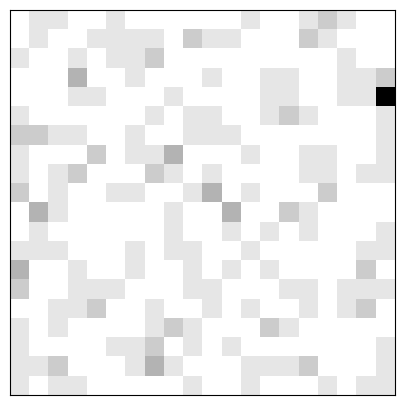

In [1077]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(data.iloc[0][0], cmap=plt.cm.binary)

def animate(frame):
    patch.set_data(data.iloc[frame][0])

anim = animation.FuncAnimation(fig, animate, frames=1000, interval=10)

In [1078]:
# anim